In [1]:
import torch
import argparse
import json
import os
import shutil
import importlib
import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import sampler
import backbone
import utils
from losses import TripletLoss

import utils
# #1. parse input parameters
# parser = argparse.ArgumentParser()
# parser.add_argument('--config', type=str, help="config for model", default="./config_mnist.json")
# parser.add_argument('--device', type=str, help="cuda device no.")
# parser.add_argument('--reset', '-r', action='store_true', help="whether or not to reset model dir.")
# input_args = parser.parse_args()


In [2]:

"""start model"""
config = './config_mnist.json'
device_no = 0

#2. setup configs
with open(config) as config_file:
    config = json.load(config_file)

root_dir = config['root_dir']
model_name = config['model_name']
lr_rate = config['lr_rate']
batch_size = config['batch_size']
n_epochs = config['n_epochs']
margin = config['margin']
patience = config['patience']

device = torch.device('cuda:{}'.format(device_no))

model_dir = os.path.join(root_dir, model_name)
# if input_args.reset and os.path.exists(model_dir): 
#     shutil.remove(model_dir)
# if not os.path.exists(model_dir): 
#     os.mkdir(model_dir)

#3. prepare the dataset
mean, std = 0.1307, 0.3081
train_dataset = MNIST(root='../data/MNIST',
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))]))
test_dataset = MNIST(root='../data/MNIST', 
                     train=False, 
                     download=True,
                     transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))]))


# online
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

viz_train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
viz_test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


#5. set up model 
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)



In [3]:
def tsne_plot(model):
    from sklearn.manifold import TSNE
    x_test, y_test = next(iter(viz_test_loader))
    x_train, y_train = next(iter(viz_train_loader))
    x_train = x_train.to(device)
    x_test = x_test.to(device)
    train_outputs = model.embedding_net(x_train)
    test_outputs = model.embedding_net(x_test)

    tsne = TSNE(random_state=0)
    train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
    test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())
    utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'start online hard TNN distribution (train set)')
    utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'start online hard TNN distribution (test set)')


In [4]:
def train(model, train_loader): 
    import sampler
    importlib.reload(sampler)      
    import sampler
    running_train_loss = 0.0
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0    

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # import pdb; pdb.set_trace()
        outputs = model.embedding_net(inputs)
        loss, pos_dist, neg_dist = sampler.online_mine_angular(labels, outputs, margin=margin, angular=True, squared=True, device=device)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        running_train_pos_dist += pos_dist.item()
        running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, max_pos_dist = {pos_dist:.5f}, max_neg_dist = {neg_dist:.5f}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
    train_neg_dist_epoch = running_train_neg_dist / len(train_loader)
    return model, train_epoch_loss, train_pos_dist_epoch, train_neg_dist_epoch

In [5]:
def test(model, test_loader):
    import sampler
    importlib.reload(sampler)      
    import sampler
    running_test_loss = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0
    
    with torch.no_grad():
        # online
        for idx, data in enumerate(test_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            loss, pos_dist, neg_dist = sampler.online_mine_angular(labels, outputs, margin=margin, angular=True, squared=True, device=device)
            running_test_loss += loss.item()
            running_test_pos_dist += pos_dist.item()
            running_test_neg_dist += neg_dist.item()             
    test_epoch_loss = running_test_loss / len(test_loader)
    test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
    test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 
    return test_epoch_loss, test_pos_dist_epoch, test_neg_dist_epoch

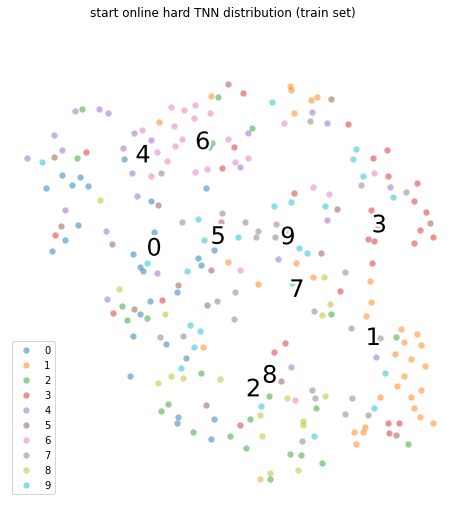

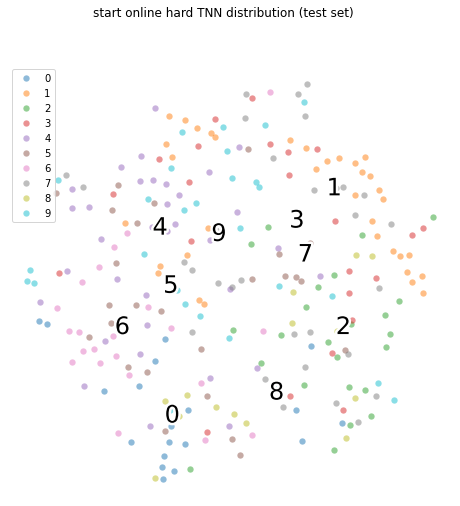

In [37]:
tsne_plot(model)

In [39]:
patience = 10
n_classes = 10
n_epochs = 10

#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    
    model, train_epoch_loss, train_pos_dist_epoch, train_neg_dist_epoch = train(model, train_loader)
    test_epoch_loss, test_pos_dist_epoch, test_neg_dist_epoch = test(model, test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, max_train_pos_dist = {train_pos_dist_epoch:.5f}, max_train_neg_dist = {train_neg_dist_epoch:.5f}\ntest_epoch_loss = {test_epoch_loss:.5f}, max_test_pos_dist = {test_pos_dist_epoch:.5f}, max_test_neg_dist = {test_neg_dist_epoch:.5f}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 220/235, loss = 0.07535, max_pos_dist = 0.02450, max_neg_dist = 0.30991
Patience= 10,train_epoch_loss = 0.07755, max_train_pos_dist = 0.02595, max_train_neg_dist = 0.30799
test_epoch_loss = 0.07424, max_test_pos_dist = 0.02210, max_test_neg_dist = 0.30843
                                                                                                    
Training @ epoch = 1, 220/235, loss = 0.07961, max_pos_dist = 0.02364, max_neg_dist = 0.30255
Patience= 9,train_epoch_loss = 0.07760, max_train_pos_dist = 0.02597, max_train_neg_dist = 0.30785
test_epoch_loss = 0.07424, max_test_pos_dist = 0.02210, max_test_neg_dist = 0.30843
                                                                                                    
Training @ epoch = 2, 220/235, loss = 0.07659, max_pos_dist = 0.02563, max_neg_dist = 0.30435
Patience= 8,train_epoch_loss = 0.07746, max_train_pos_dist = 0.02590, max_train_neg_dist = 0.30802
test_epoch_loss = 0.07424, max_test_pos_dist = 0.0

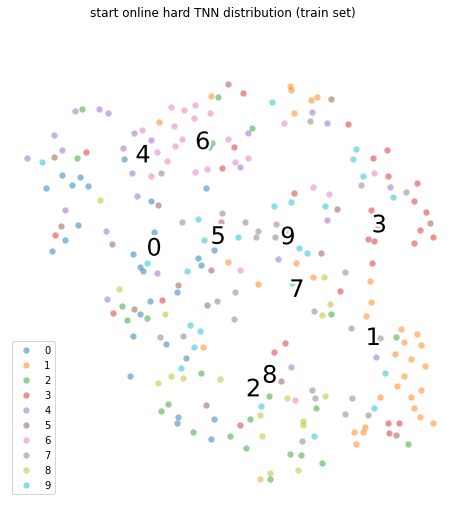

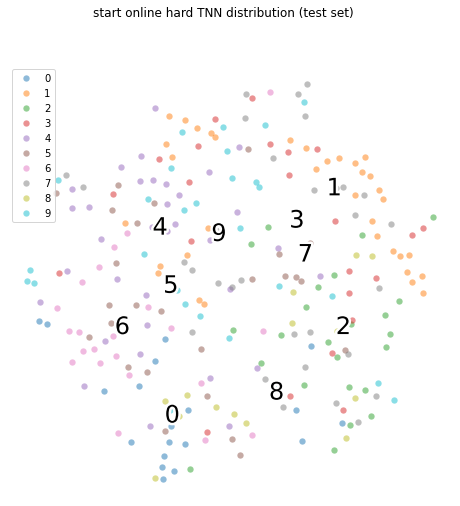

In [40]:
tsne_plot(model)

In [10]:

#3. prepare the dataset
mean, std = 0.1307, 0.3081
train_dataset = MNIST(root='../data/MNIST',
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))]))
test_dataset = MNIST(root='../data/MNIST', 
                     train=False, 
                     download=True,
                     transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))]))
n_classes = 10

#4.sampler 

# offline
# X_train, X_test = sampler.offline_batching(train_dataset.data.unsqueeze(1).numpy(), train_dataset.targets.numpy(), ap_pairs=100, an_pairs=100, test_frac=0.2) # X, y --> x_pos, x_anchor, x_neg
# train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float()), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float()), batch_size=batch_size)

# online
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#5. set up model 
embedding_net = backbone.EmbeddingNet()
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)

#6. 


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0

    # train
    # offline
    # for idx, (data,) in enumerate(train_loader):
        # offline
        # inputs = data.to(device)
        # optimizer.zero_grad()
        # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
        # loss = loss_fn(anchor, positive, negative)
        # loss.backward()

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels  = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # import pdb; pdb.set_trace()
        outputs = model.embedding_net(inputs)

        # import pdb; pdb.set_trace();
        loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, pos_mask = {pos_mask}, neg_mask = {neg_mask}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(train_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)

            running_test_loss += loss.item()
    test_epoch_loss = running_test_loss / len(test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_improved = epoch

        #TODO pickle the best embeddings
        #TODO add TSNE plotting
        #TODO tensorboard

    epoch +=1
    print(f"\nPatience= {patience}, train_epoch_loss = {train_epoch_loss}, test_epoch_loss = {test_epoch_loss}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 220/235, loss = 0.05082, pos_mask = 0.020896315574645996, neg_mask = 0.77678108215332037
Patience= 20, train_epoch_loss = 0.05515976570388104, test_epoch_loss = 0.30295289494097233
                                                                                                    
Training @ epoch = 1, 220/235, loss = 0.03962, pos_mask = 0.014443699270486832, neg_mask = 0.7290645837783813
Patience= 20, train_epoch_loss = 0.04373683434851626, test_epoch_loss = 0.2410264540463686
                                                                                                    
Training @ epoch = 2, 220/235, loss = 0.03452, pos_mask = 0.008967146277427673, neg_mask = 0.6501962542533875
Patience= 20, train_epoch_loss = 0.038454044435886625, test_epoch_loss = 0.21630112174898386
                                                                                                    
Training @ epoch = 3, 220/235, loss = 0.03374, pos_mask = 0.008038065396249294, neg_mask =

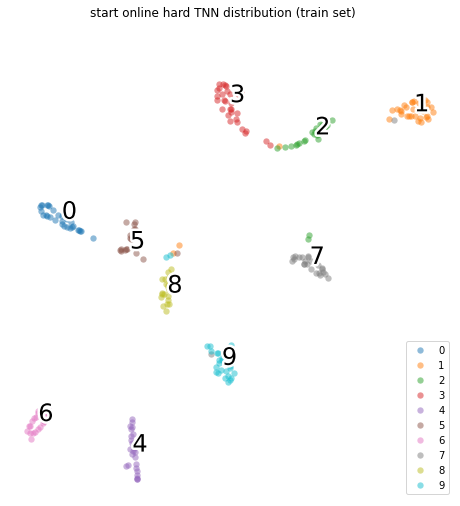

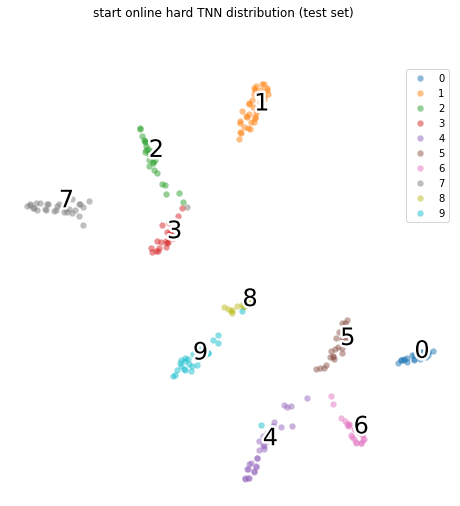

In [11]:
tsne_plot(model)

In [7]:

#3. prepare the dataset
mean, std = 0.1307, 0.3081
train_dataset = MNIST(root='../data/MNIST',
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))]))
test_dataset = MNIST(root='../data/MNIST', 
                     train=False, 
                     download=True,
                     transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))]))
n_classes = 10

#4.sampler 

# offline
# X_train, X_test = sampler.offline_batching(train_dataset.data.unsqueeze(1).numpy(), train_dataset.targets.numpy(), ap_pairs=100, an_pairs=100, test_frac=0.2) # X, y --> x_pos, x_anchor, x_neg
# train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float()), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float()), batch_size=batch_size)

# online
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#5. set up model 
embedding_net = backbone.EmbeddingNet()
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)
ce_loss = torch.nn.CrossEntropyLoss()

#6. 


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0

    # train
    # offline
    # for idx, (data,) in enumerate(train_loader):
        # offline
        # inputs = data.to(device)
        # optimizer.zero_grad()
        # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
        # loss = loss_fn(anchor, positive, negative)
        # loss.backward()

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels  = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # import pdb; pdb.set_trace()
        embeddings = model.embedding_net.get_embedding(inputs)
        outputs = model.embedding_net(inputs)

        # import pdb; pdb.set_trace();
        metric_loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)
        xe_loss = ce_loss(outputs, labels)

        loss = xe_loss + metric_loss
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, pos_mask = {pos_mask}, neg_mask = {neg_mask}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(train_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            metric_loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)
            xe_loss = ce_loss(outputs, labels)
            loss = xe_loss + metric_loss
            running_test_loss += loss.item()
    test_epoch_loss = running_test_loss / len(test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_improved = epoch

        #TODO pickle the best embeddings
        #TODO add TSNE plotting
        #TODO tensorboard

    epoch +=1
    print(f"\nPatience= {patience}, train_epoch_loss = {train_epoch_loss}, test_epoch_loss = {test_epoch_loss}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 220/235, loss = 2.19874, pos_mask = 0.026783373206853867, neg_mask = 0.64396804571151738958
Patience= 20, train_epoch_loss = 2.2545171230397325, test_epoch_loss = 12.626820069551467
                                                                                                    
Training @ epoch = 1, 220/235, loss = 1.97446, pos_mask = 0.036988429725170135, neg_mask = 0.8041415810585022
Patience= 20, train_epoch_loss = 2.089264225959778, test_epoch_loss = 11.824500104784965
                                                                                                    
Training @ epoch = 2, 220/235, loss = 1.91162, pos_mask = 0.02636139653623104, neg_mask = 0.81221312284469619
Patience= 20, train_epoch_loss = 1.9862066867503714, test_epoch_loss = 11.554456275701522
                                                                                                    
Training @ epoch = 3, 220/235, loss = 1.91702, pos_mask = 0.028533777222037315, neg_mask = 0.7

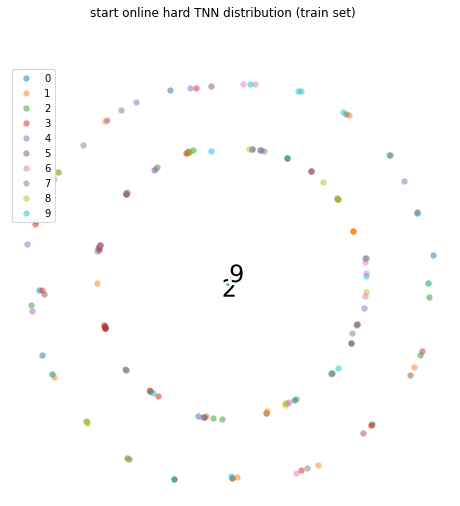

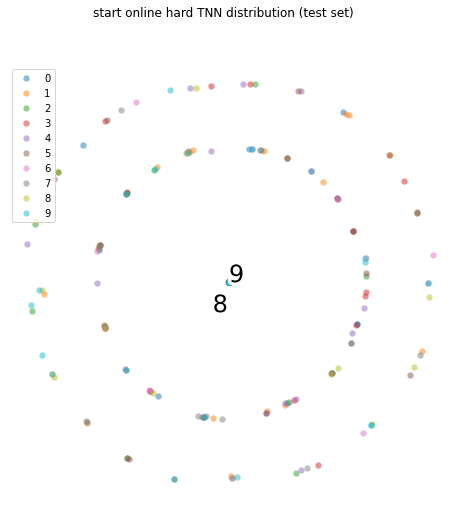

In [8]:
tsne_plot(model)

In [6]:


#5. set up model 
embedding_net = backbone.EmbeddingNet()
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)
nll_loss = torch.nn.NLLLoss()

#6. 


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0

    # train
    # offline
    # for idx, (data,) in enumerate(train_loader):
        # offline
        # inputs = data.to(device)
        # optimizer.zero_grad()
        # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
        # loss = loss_fn(anchor, positive, negative)
        # loss.backward()

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels  = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # import pdb; pdb.set_trace()
        embeddings = model.embedding_net.get_embedding(inputs)
        outputs = model.embedding_net(inputs)

        # import pdb; pdb.set_trace();
        metric_loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)
        xe_loss = nll_loss(outputs, labels)
        loss = xe_loss + (0.5*metric_loss)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, pos_mask = {pos_mask}, neg_mask = {neg_mask}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    # import pdb; pdb.set_trace()
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(train_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            metric_loss, pos_mask, neg_mask = sampler.online_mine_angular(labels, outputs, angular=True, margin=margin, squared=True, device=device)
            xe_loss = nll_loss(outputs, labels)
            loss = xe_loss + (0.5*metric_loss)


            #1. get the x_p, x_n --> use our sampler --> our embedding net
            #2. get x_p' --> use an attack --> (pgd/fgsm/online invariance)
            # loss = metric_loss

            running_test_loss += loss.item()
    test_epoch_loss = running_test_loss / len(test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_improved = epoch

        #TODO pickle the best embeddings
        #TODO add TSNE plotting
        #TODO tensorboard

    epoch +=1
    print(f"\nPatience= {patience}, train_epoch_loss = {train_epoch_loss}, test_epoch_loss = {test_epoch_loss}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 220/235, loss = 2.87943, pos_mask = 0.005306068807840347, neg_mask = 0.12735021114349365305
Patience= 20, train_epoch_loss = 2.2554019491723243, test_epoch_loss = 9.652694216370582
                                                                                                    
Training @ epoch = 1, 220/235, loss = 1.72824, pos_mask = 0.004753153771162033, neg_mask = 0.163289278745651255
Patience= 20, train_epoch_loss = 2.2592532979681135, test_epoch_loss = 10.024093079566956
                                                                                                    
Training @ epoch = 2, 220/235, loss = 1.54911, pos_mask = 0.00782779511064291, neg_mask = 0.2231124341487884535
Patience= 20, train_epoch_loss = 2.0268874036504867, test_epoch_loss = 9.747272741794585
                                                                                                    
Training @ epoch = 3, 220/235, loss = 1.21179, pos_mask = 0.004311453551054001, neg_mask = 

KeyboardInterrupt: 

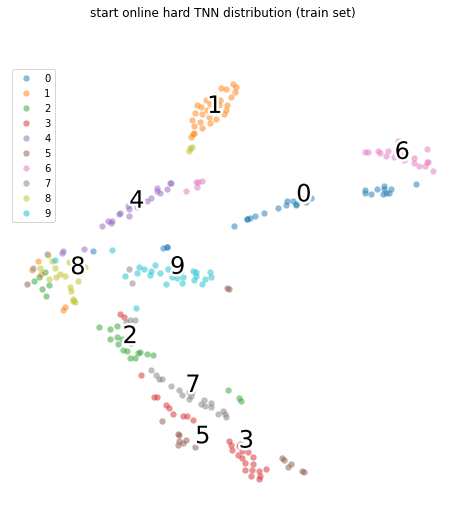

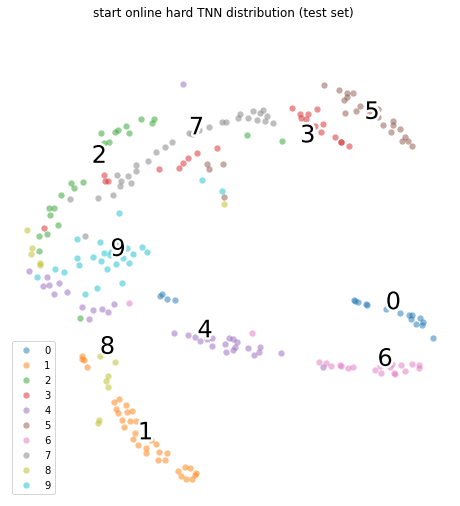

In [7]:
tsne_plot(model)

In [13]:
examples = enumerate(test_loader)

In [16]:

batch_idx, (example_data, example_targets) = next(examples)

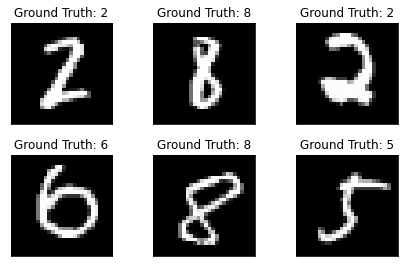

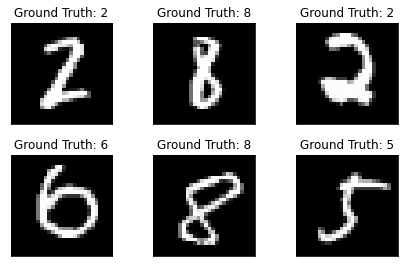

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

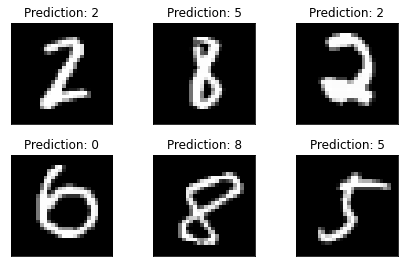

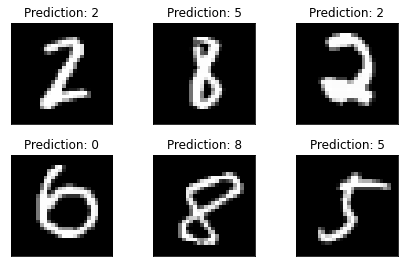

In [18]:
with torch.no_grad():
    example_data = example_data.to(device)
    output = model.embedding_net(example_data)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    cpu_example_data = example_data.cpu()
    plt.imshow(cpu_example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

# old

#### euclidiean distance #####

In [12]:
#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    
    train_epoch_loss, train_pos_dist_epoch, train_neg_dist_epoch = train(model, train_loader)
    test_epoch_loss, test_pos_dist_epoch, test_neg_dist_epoch = test(model, test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

    epoch +=1
    print(f"\nPatience= {patience},train_epoch_loss = {train_epoch_loss:.5f}, max_train_pos_dist = {train_pos_dist_epoch:.5f}, max_train_neg_dist = {train_neg_dist_epoch:.5f}\ntest_epoch_loss = {test_epoch_loss:.5f}, max_test_pos_dist = {test_pos_dist_epoch:.5f}, max_test_neg_dist = {test_neg_dist_epoch:.5f}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 3740/3750, loss = 0.00000, max_pos_dist = 0.13947, max_neg_dist = 2.29398
Patience= 20,train_epoch_loss = 0.03265, max_train_pos_dist = 0.21174, max_train_neg_dist = 1.78939
test_epoch_loss = 0.02509, max_test_pos_dist = 0.16881, max_test_neg_dist = 2.12154
                                                                                                    
Training @ epoch = 1, 3740/3750, loss = 0.00388, max_pos_dist = 0.27825, max_neg_dist = 1.23151
Patience= 20,train_epoch_loss = 0.02309, max_train_pos_dist = 0.19710, max_train_neg_dist = 1.99300
test_epoch_loss = 0.02221, max_test_pos_dist = 0.13007, max_test_neg_dist = 1.63861
                                                                                                    
Training @ epoch = 2, 3740/3750, loss = 0.00000, max_pos_dist = 0.20158, max_neg_dist = 1.95793
Patience= 20,train_epoch_loss = 0.01677, max_train_pos_dist = 0.16393, max_train_neg_dist = 1.98285
test_epoch_loss = 0.01634, max_test_pos_di

In [20]:
outputs

tensor([[-0.0308,  0.0234, -0.0326,  0.0019],
        [-0.0307,  0.0233, -0.0328,  0.0018],
        [-0.0308,  0.0228, -0.0329,  0.0019],
        ...,
        [-0.0309,  0.0231, -0.0323,  0.0019],
        [-0.0310,  0.0229, -0.0329,  0.0015],
        [-0.0310,  0.0227, -0.0327,  0.0021]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [21]:
outputs.shape

torch.Size([512, 4])

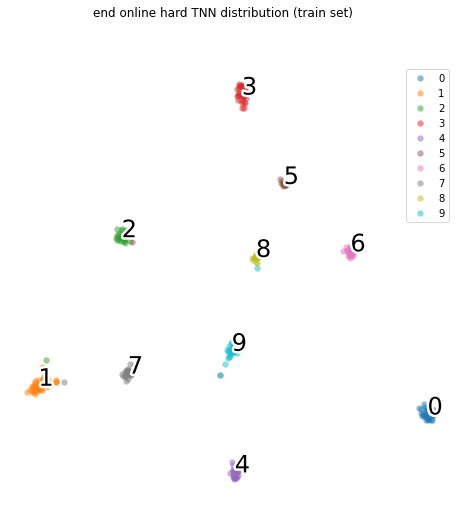

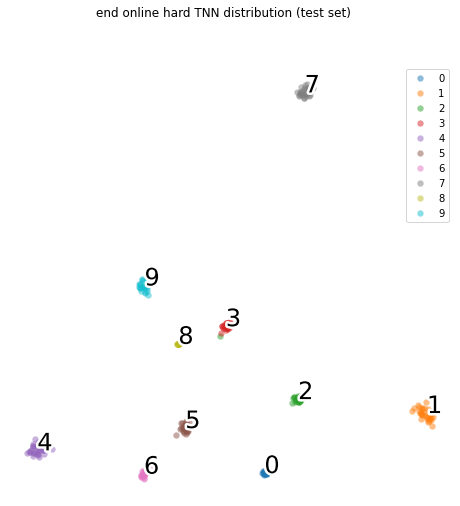

In [44]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'end online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'end online hard TNN distribution (test set)')


## angular distance #####

In [12]:
#7. train
embedding_net = backbone.EmbeddingNet() # get dim
model = backbone.TripletNet(embedding_net)
model.to(device)

last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0
    
    # i expect the pos mask distance to be decreasing 
    # and the neg mask distance to be increasing
    running_train_pos_dist = 0.0
    running_train_neg_dist = 0.0
    running_test_pos_dist = 0.0
    running_test_neg_dist = 0.0

    # train
    # offline
    # for idx, (data,) in enumerate(train_loader):
        # offline
        # inputs = data.to(device)
        # optimizer.zero_grad()
        # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
        # loss = loss_fn(anchor, positive, negative)
        # loss.backward()

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        # import pdb; pdb.set_trace()
        outputs = model.embedding_net(inputs)

        loss, pos_dist, neg_dist = sampler.online_mine_angular(labels, outputs, margin=margin, squared=True, device=device)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        running_train_pos_dist += pos_dist.item()
        running_train_neg_dist += neg_dist.item()        
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, max_pos_dist = {pos_dist}, max_neg_dist = {neg_dist}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    train_pos_dist_epoch = running_train_pos_dist / len(train_loader)
    train_neg_dist_epoch = running_train_neg_dist / len(train_loader)    
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(test_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            loss, pos_dist, neg_dist = sampler.online_mine_angular(labels, outputs, margin=margin, squared=True, device=device)
            running_test_loss += loss.item()
            running_test_pos_dist += pos_dist.item()
            running_test_neg_dist += neg_dist.item()             
    test_epoch_loss = running_test_loss / len(test_loader)
    test_pos_dist_epoch = running_test_pos_dist / len(test_loader)
    test_neg_dist_epoch = running_test_neg_dist / len(test_loader) 

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_epoch_improved = epoch
    else:
        patience-=1

        #TODO pickle the best embeddings
        #TODO add TSNE plotting
        #TODO tensorboard

    epoch +=1
    print(f"\nPatience= {patience},\n train_epoch_loss = {train_epoch_loss:.5f}, max_train_pos_dist = {train_pos_dist_epoch:.5f}, max_train_neg_dist = {train_neg_dist_epoch:.5f}\ntest_epoch_loss = {test_epoch_loss:.5f}, max_test_pos_dist = {test_pos_dist_epoch:.5f}, max_test_neg_dist = {test_neg_dist_epoch:.5f}")
    print(" "*100)
print('Finished Training!!')

improvement!poch = 0, 220/235, loss = 1.29995, max_pos_dist = 0.9048944711685181, max_neg_dist = 0.15045104920864105

Patience= 20,
 train_epoch_loss = 1.29980, max_train_pos_dist = 0.90367, max_train_neg_dist = 0.15031
test_epoch_loss = 1.30257, max_test_pos_dist = 0.90573, max_test_neg_dist = 0.14885
                                                                                                    
no improvementch = 1, 220/235, loss = 1.29447, max_pos_dist = 0.9061113595962524, max_neg_dist = 0.15655805170536045

Patience= 19,
 train_epoch_loss = 1.29992, max_train_pos_dist = 0.90372, max_train_neg_dist = 0.15022
test_epoch_loss = 1.30257, max_test_pos_dist = 0.90573, max_test_neg_dist = 0.14885
                                                                                                    
no improvementch = 2, 220/235, loss = 1.29484, max_pos_dist = 0.904081404209137, max_neg_dist = 0.155348628759384164

Patience= 18,
 train_epoch_loss = 1.29967, max_train_pos_dist = 0.90357,

KeyboardInterrupt: 

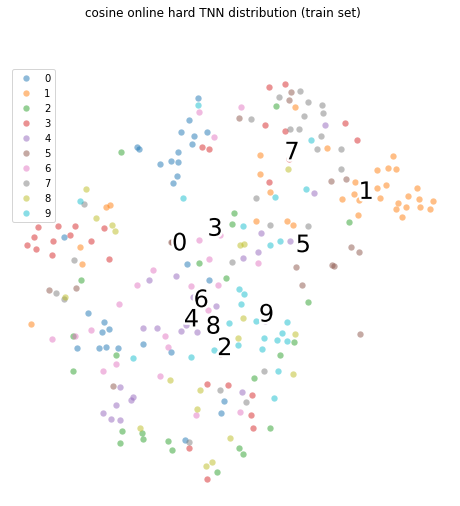

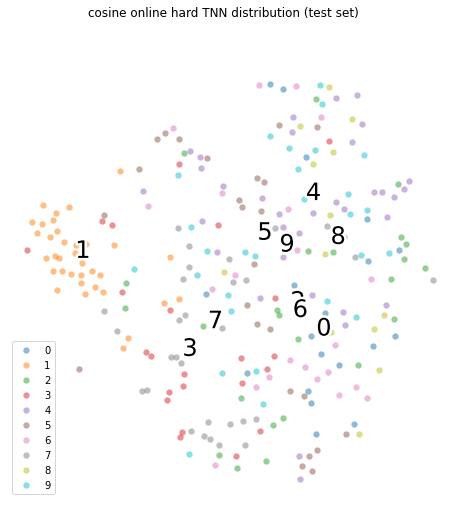

In [13]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')


In [10]:
#3. prepare the dataset
mean, std = 0.1307, 0.3081
train_dataset = MNIST(root='../data/MNIST',
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))]))
test_dataset = MNIST(root='../data/MNIST', 
                     train=False, 
                     download=True,
                     transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((mean,), (std,))]))
n_classes = 10

#4.sampler 

# offline
# X_train, X_test = sampler.offline_batching(train_dataset.data.unsqueeze(1).numpy(), train_dataset.targets.numpy(), ap_pairs=100, an_pairs=100, test_frac=0.2) # X, y --> x_pos, x_anchor, x_neg
# train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float()), batch_size=batch_size)
# test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float()), batch_size=batch_size)

# online
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


#5. set up model 
embedding_net = backbone.EmbeddingNet()
model = backbone.TripletNet(embedding_net)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
loss_fn = TripletLoss(margin=margin)

#6. 


#7. train
last_epoch_improved = 0
epoch = 0
best_loss = np.inf

while epoch - last_epoch_improved < patience:
    running_train_loss = 0.0
    running_test_loss = 0.0

    # train
    # offline
    # for idx, (data,) in enumerate(train_loader):
        # offline
        # inputs = data.to(device)
        # optimizer.zero_grad()
        # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
        # loss = loss_fn(anchor, positive, negative)
        # loss.backward()

    for idx, data in enumerate(train_loader):
        # online
        inputs, labels  = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # import pdb; pdb.set_trace()
        outputs = model.embedding_net(inputs)

        loss, pos_mask, neg_mask = sampler.online_mine_hard(labels, outputs, angular=True, margin=margin, squared=True, device=device)
        loss.backward()

        optimizer.step()
        running_train_loss += loss.item()
        if idx%20 == 0:
            # offline
            # print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}", end='\r')

            #online
            print(f"Training @ epoch = {epoch}, {idx}/{len(train_loader)}, loss = {loss:.5f}, pos_mask = {pos_mask}, neg_mask = {neg_mask}", end='\r')
    train_epoch_loss = running_train_loss / len(train_loader)
    
    # test
    with torch.no_grad():
        # offline
        # for idx, (data,) in enumerate(test_loader):
            # inputs = data.to(device)
            # anchor, positive, negative = model(x1=inputs[:,0], x2=inputs[:,1], x3=inputs[:,2])
            # loss = loss_fn(anchor, positive, negative)
        # online
        for idx, data in enumerate(train_loader):
            inputs, labels  = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.embedding_net(inputs)
            loss, pos_mask, neg_mask = sampler.online_mine_hard(labels, outputs, angular=True, margin=margin, squared=True, device=device)
            running_test_loss += loss.item()
    test_epoch_loss = running_test_loss / len(test_loader)

    # save model/ embedding info
    if test_epoch_loss < best_loss:
        torch.save(model, os.path.join(model_dir, 'model'))
        best_loss = test_epoch_loss
        last_improved = epoch

        #TODO pickle the best embeddings
        #TODO add TSNE plotting
        #TODO tensorboard

    epoch +=1
    print(f"\nPatience= {patience}, train_epoch_loss = {train_epoch_loss}, test_epoch_loss = {test_epoch_loss}")
    print(" "*100)
print('Finished Training!!')

Training @ epoch = 0, 220/235, loss = 0.20001, pos_mask = 7.265480235219002e-06, neg_mask = -1.4435499906539917e-088
Patience= 20, train_epoch_loss = 0.20103367009061449, test_epoch_loss = 1.175044669955969
                                                                                                    
Training @ epoch = 1, 220/235, loss = 0.20000, pos_mask = 2.0063016563653946e-06, neg_mask = -6.798654794692993e-08
Patience= 20, train_epoch_loss = 0.20000442837147003, test_epoch_loss = 1.1750121016055346
                                                                                                    
Training @ epoch = 2, 220/235, loss = 0.20000, pos_mask = 5.390029400587082e-07, neg_mask = -9.359791874885559e-088
Patience= 20, train_epoch_loss = 0.20000117617718716, test_epoch_loss = 1.1750035721808672
                                                                                                    
Training @ epoch = 3, 220/235, loss = 0.20000, pos_mask = 2.1327286958694458

KeyboardInterrupt: 

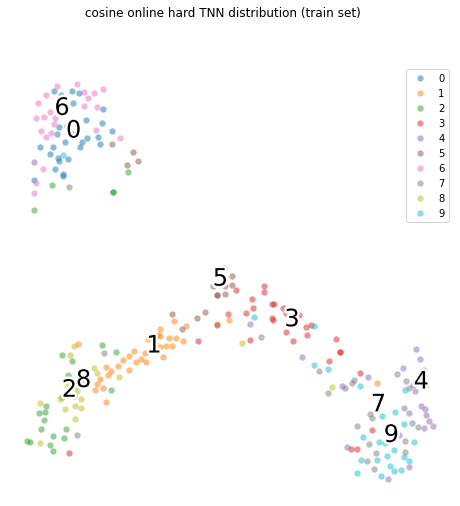

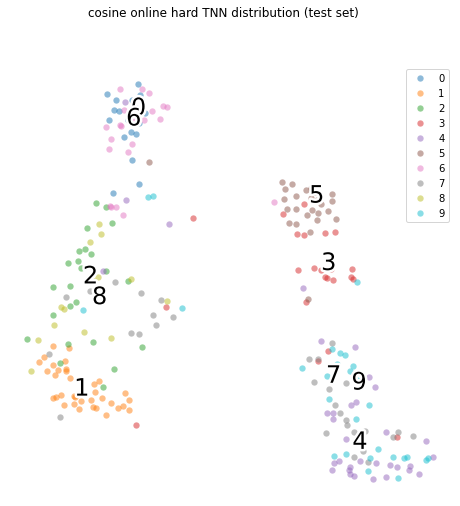

In [15]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')


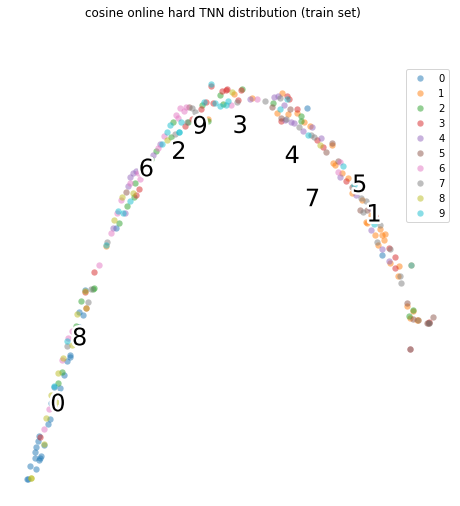

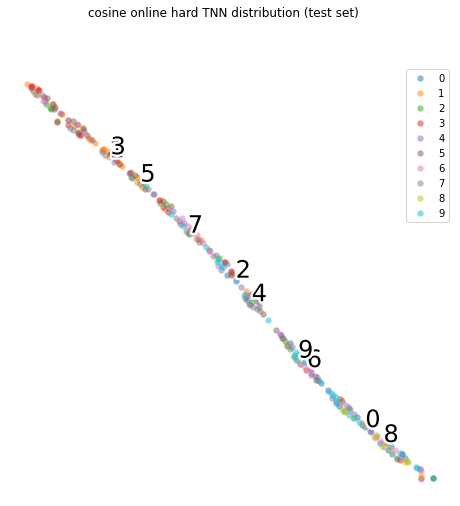

In [15]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')


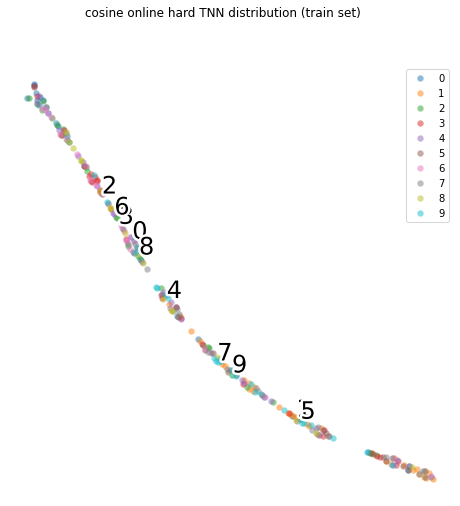

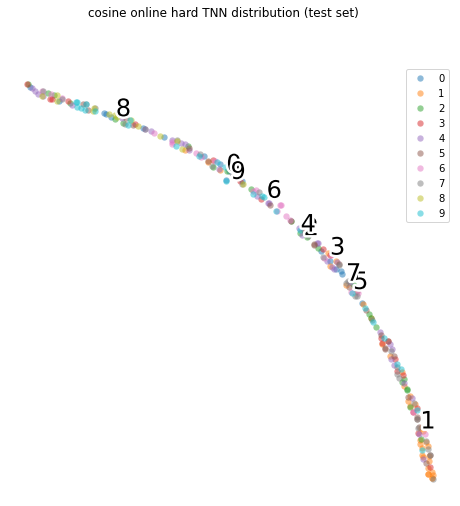

In [11]:
train_outputs = model.embedding_net(x_train)
test_outputs = model.embedding_net(x_test)

tsne = TSNE(random_state=0)
train_tsne_embeds = tsne.fit_transform(train_outputs.cpu().detach().numpy())
test_tsne_embeds = tsne.fit_transform(test_outputs.cpu().detach().numpy())

utils.scatter(train_tsne_embeds, y_train.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (train set)')
utils.scatter(test_tsne_embeds, y_test.cpu().numpy(), subtitle=f'cosine online hard TNN distribution (test set)')
